### **We are creating a betting app, that hopefully helps the user place smarter bets. How do we do this?**
###### let's think ##

### Bets are based on what? ###
- Team stats (+/- OU, ML)
- Player Stats (Pts, Reb, Ast)
- Game-based Stats (First to X, First-half)
- Stat Combinations (Pts+Reb, Double-Double)

We will need a way to:
1. Intake stats from sources (Web, CSV, SQL, etc.)
2. Relational db of players with stats
3. Analyze via functions

Keeping simplicity in mind, the easiest functionality we can code is accessing a single player's stats (we'll use points) for the current 2022 NBA Season.

CSV's would be an easy choice, but it will be outdated as the season progresses. 
We could manually code a web-scraper, but this would require a long time investment and time is valuable.
API commands to pull from a source are a good compromise.

For now, let's deal with CSV's.

In [4]:
import pandas as pd # Module Importing
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/Users/kareemtaha/Downloads/2022-2023 NBA Player Stats - Regular.csv', sep=";", index_col=0, encoding = 'latin') # the csv uses colons (;) instead of commas (,) to separate values
#df = df.drop(columns="Rk") # drop unnecessary Rk column. Useful if we used player names as our index, but that complicates functions later, so we just leave RK.
df

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
Rk,,,,,,,,,,,,,,,,,,,,,
1,Precious Achiuwa,C,23,TOR,12,0,20.4,3.0,7.7,0.391,...,0.848,2.0,5.0,7.0,1.3,0.2,0.6,1.3,1.6,8.8
2,Steven Adams,C,29,MEM,15,15,26.0,2.9,4.7,0.629,...,0.257,4.9,5.8,10.7,2.4,0.7,1.1,2.3,2.7,6.5
3,Bam Adebayo,C,25,MIA,14,14,35.0,7.4,14.0,0.531,...,0.855,2.4,6.7,9.1,3.4,1.2,0.8,3.6,3.4,19.1
4,Ochai Agbaji,SG,22,UTA,6,0,11.2,1.3,3.2,0.421,...,0.571,0.7,1.0,1.7,0.2,0.0,0.0,0.0,1.0,3.3
5,Santi Aldama,PF,22,MEM,16,14,27.3,3.8,8.1,0.465,...,0.679,1.8,4.5,6.3,0.9,0.9,1.1,0.6,2.7,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
460,Delon Wright,PG,30,WAS,4,0,22.8,2.5,6.0,0.417,...,0.600,1.0,1.5,2.5,3.3,2.8,1.0,1.0,1.3,6.5
461,McKinley Wright IV,PG,24,DAL,1,0,5.0,1.0,4.0,0.250,...,0.000,1.0,1.0,2.0,2.0,1.0,0.0,0.0,0.0,2.0
462,Thaddeus Young,PF,34,TOR,14,4,16.4,2.3,4.1,0.561,...,0.800,1.8,2.0,3.8,1.6,1.1,0.1,0.6,1.6,5.2


Great! We have our players this season, their teams, and their stats. Let's return one player.

In [3]:
df.query('Player=="Marcus Smart"') # via query
df[df['Player'] == 'Marcus Smart'] # via series (same code)

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
Rk,,,,,,,,,,,,,,,,,,,,,
391,Marcus Smart,PG,28,BOS,14,14,32.7,4.1,9.7,0.419,...,0.828,0.3,2.9,3.2,7.1,1.1,0.3,1.6,3.1,11.4


In [4]:
All_Stats = df.columns.values.tolist()
Qual_Stats = ["Pos", "Tm"]
Quant_Stats = ["Age", "G", "GS", "MP", "PTS", "FG", "FGA", "FG%", "3P", "3PA", "3P%", "2P","2PA","2P%","eFG%","FT","FTA","FT%","ORB","DRB","TRB","AST","STL","BLK","TOV","PF"]

In [5]:
def Get_Players_df(d, players, stats = Quant_Stats.copy()):
    if stats != None: #User specifies certain stats (non-default)
        stats = stats.copy()
        try: assert "Player" in stats #Makes sure that when we shrink the df to those stats, we don't accidentally remove the Player Name col (needed for compares)
        except AssertionError: stats.append("Player") 
        d = d[stats]
    return d[d['Player'].isin(players)]

pd.concat([Get_Players_df(df, ["Damian Lillard", "Stephen Curry", "Kevin Durant"], All_Stats), 
            Get_Players_df(df, ["LeBron James"], All_Stats), 
            Get_Players_df(df, ["Josh Hart", "Nassir Little"], All_Stats)])

,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
Rk,,,,,,,,,,,,,,,,,,,,,
95,Stephen Curry,PG,34,GSW,15,15,34.6,10.9,20.6,0.528,...,0.909,0.6,6.1,6.7,6.6,1.1,0.1,2.7,2.0,32.2
120,Kevin Durant,PF,34,BRK,16,16,36.8,10.3,19.4,0.529,...,0.913,0.4,6.2,6.6,5.2,0.8,1.8,3.3,2.6,30.6
253,Damian Lillard,PG,32,POR,11,11,35.2,7.6,18.1,0.422,...,0.875,0.9,3.4,4.3,7.0,0.5,0.3,3.8,1.6,26.3
209,LeBron James,PF,38,LAL,10,10,35.7,10.0,21.9,0.457,...,0.667,1.8,7.0,8.8,6.9,1.1,0.7,3.4,2.0,24.9
175,Josh Hart,SG,27,POR,16,16,35.4,3.3,7.3,0.444,...,0.723,1.7,6.7,8.4,4.1,1.4,0.2,1.6,2.6,9.2
254,Nassir Little,PF,22,POR,16,0,14.7,2.3,4.5,0.514,...,0.688,0.3,2.3,2.6,0.9,0.4,0.2,0.6,0.7,6.3


We can now compare two players current league stats. Neat.

Next, let's see some visuals since I am tired of seeing words and text.

['Stephen Curry',
 34,
 15,
 15,
 34.6,
 32.2,
 10.9,
 20.6,
 52.8,
 5.1,
 11.6,
 44.3,
 5.7,
 9.0,
 63.7,
 65.2,
 5.3,
 5.9,
 90.9,
 0.6,
 6.1,
 6.7,
 6.6,
 1.1,
 0.1,
 2.7,
 2.0]

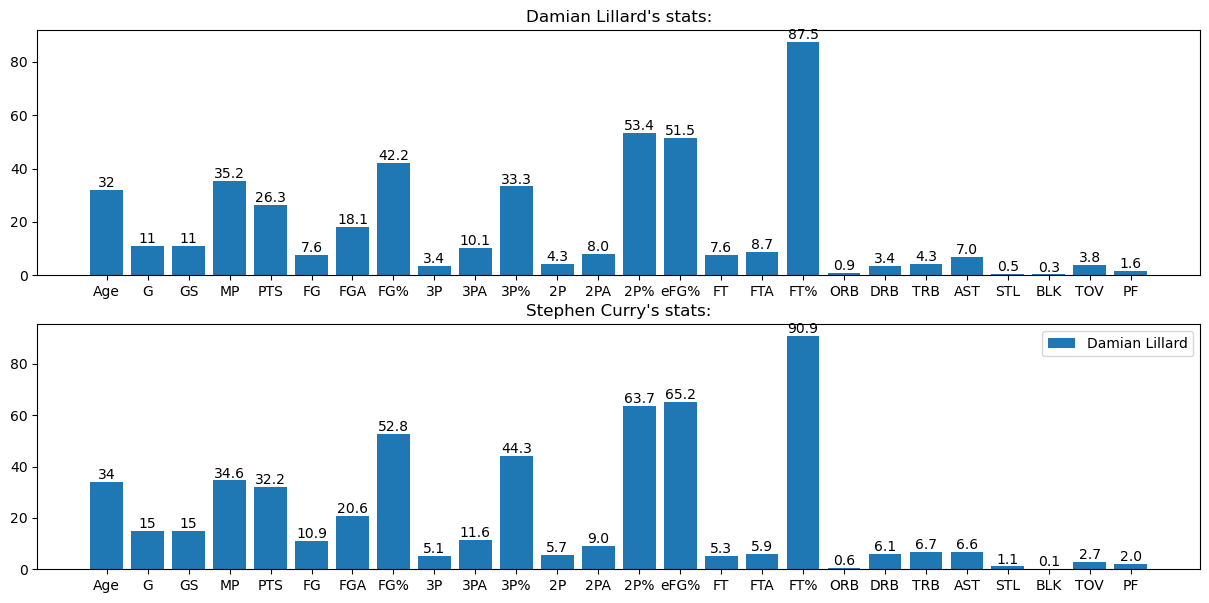

In [6]:
def Visualize_Stats(d, players, stats = Quant_Stats, to_list = False, stacked_bar = False):
    try: assert len(stats) > 0# Stats Setup - Ensure we don't accidentally remove the Player Name col (needed for compares) {
    except AssertionError: stats = ["PTS"] # .. 
    stats = stats.copy()
    d = d[["Player"] + stats]                  # .. - shrink to stats (retain player to search their stats later)                          # ..
    stat_df = Get_Players_df(d, players, stats = stats)

    num_players = len(players)                 # .. } Stats Setup
    if num_players > 1 and stacked_bar == False: fig, ax = plt.subplots(num_players, figsize=(15,3.5 * num_players))
    else: plt.figure(figsize=(15,3.5))
    return_stats = []

    for i in range(num_players):
        player_df = stat_df[stat_df['Player'] == players[i]]   
        player_stats = []  

        for stat in stats:
            value = player_df[stat].iat[0]
            if "%" in stat: value *= 100
            if type(value) != str: value = round(value,2);player_stats.append(value)

        if stacked_bar:                 # If graph is stacked
            plt.title(f"{players} stat comparison:")
            b = plt.bar(x = stats, height = player_stats) ; plt.bar_label(b, player_stats) # Add player stats to the bars
        else:
            match num_players: # Non-stacked graph: Check how many players
                case 1: # 1 player : Use one graph
                    plt.title(f"{players[i]}'s stats:")
                    b = plt.bar(x = stats, height = player_stats) 
                    plt.bar_label(b, player_stats)#if !to_list: (complete this if block if you want to_list to not also graph stats
                case _: # 2+ players : Use 2+ graphs
                    ax[i].set_title(f"{players[i]}'s stats:")
                    b = ax[i].bar(x=stats, height=player_stats) ; ax[i].bar_label(b, player_stats)#if !to_list: (complete this if block if you want to_list to not also graph stats
        
        return_stats.append([players[i]] + player_stats) # Add player stats to all stats to return
    
    plt.legend(players)
    if to_list: return return_stats

#Visualize_Stats(df, players = ["Damian Lillard"])
#Visualize_Stats(df, players = ["Damian Lillard"], to_list=True)
#Visualize_Stats(df, players = ["Damian Lillard", "Josh Hart"], stats=Quant_Stats, stacked_bar=True)
f = Visualize_Stats(df, players = ["Damian Lillard", "Stephen Curry"], to_list=True)
f[1]


We can now visualize a player's stats and compare them to someone else's.
## What do we do now?

###### Great question

What values do we want to extrapolate?

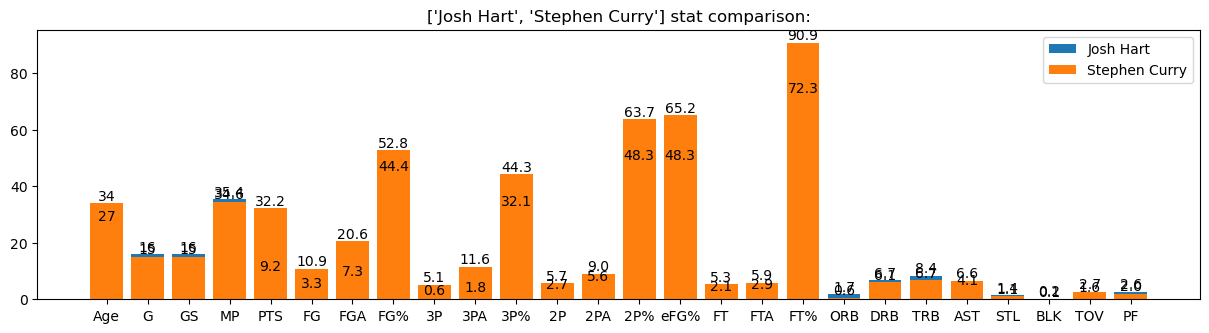

In [8]:
def Compare_Players(d, stacked_bar = False):
    selected = []
    players = d['Player'].values
    player = input("Which player's stats would you like to see? (' ' to terminate)")

    while player in players:
        selected.append(player)
        player = input("Which player's stats would you like to see? (' ' to terminate)")
    
    if len(selected) > 0: Visualize_Stats(d, selected, stacked_bar = stacked_bar)
    else: print("No players given!")

#Compare_Players(df)
Compare_Players(df, True)




In [ ]:
Functions = [ 
            Get_Players_df, 
            Visualize_Stats, 
            Compare_Players
            ]

Not bad, but now we need to work with more insightful data than season averages if we want to do advanced computations. Let's get game-by-game info's for players (We'll use LeBron's stats from (https://www.basketball-reference.com/players/j/jamesle01/gamelog/2023)).

In [8]:
lebron_2023_html = pd.read_html("https://www.basketball-reference.com/players/j/jamesle01/gamelog/2023#pgl_basic", match="Regular Season")[0].copy() # returns html tables list
lebron_2023_html


,Rk,G,Date,Age,Tm,Unnamed: 5,Opp,Unnamed: 7,GS,MP,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-
0,1,1,2022-10-18,37-292,LAL,@,GSW,L (-14),1,35:12,...,10,15,8,0,0,5,2,31,23.9,-10
1,2,2,2022-10-20,37-294,LAL,NaN,LAC,L (-6),1,36:40,...,8,10,6,1,2,2,3,20,17.3,-1
2,3,3,2022-10-23,37-297,LAL,NaN,POR,L (-2),1,37:43,...,7,8,8,2,2,4,3,31,26.2,+2
3,4,4,2022-10-26,37-300,LAL,@,DEN,L (-11),1,35:18,...,5,7,9,1,0,8,1,19,8.9,-7
4,5,5,2022-10-28,37-302,LAL,@,MIN,L (-9),1,37:27,...,4,7,5,4,0,3,2,28,21.8,-13
5,6,6,2022-10-30,37-304,LAL,NaN,DEN,W (+11),1,34:42,...,6,6,8,1,0,3,1,26,19.2,-1
6,7,7,2022-11-02,37-307,LAL,NaN,NOP,W (+3),1,39:43,...,10,10,8,0,2,2,3,20,13.5,+5
7,8,8,2022-11-04,37-309,LAL,NaN,UTA,L (-14),1,34:09,...,8,10,8,0,1,3,3,17,11.6,-11
8,9,9,2022-11-06,37-311,LAL,NaN,CLE,L (-14),1,33:49,...,5,7,4,0,0,1,0,27,19.6,-8
9,10,NaN,2022-11-07,37-312,LAL,@,UTA,L (-23),Inactive,Inactive,...,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive,Inactive


In [9]:
lebron_2023 = lebron_2023_html.copy() # re-copy from the html table to not accidentally overwrite data
lebron_2023.rename(columns = {'Unnamed: 5':'Away', 'Unnamed: 7': 'Result'}, inplace = True) # Rename columns properly
lebron_2023.set_index('Rk', inplace = True) # Set the Rk number (team game) as the index
lebron_2023['Away'].mask(lebron_2023['Away'] == '@', True, inplace=True) ; lebron_2023['Away'] = lebron_2023['Away'].fillna(False) # replace values in away column with bool
lebron_2023.dropna(subset=['G']) # drop unplayed games


,G,Date,Age,Tm,Away,Opp,Result,GS,MP,FG,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-
Rk,,,,,,,,,,,,,,,,,,,,,
1,1,2022-10-18,37-292,LAL,True,GSW,L (-14),1,35:12,12,...,10,15,8,0,0,5,2,31,23.9,-10
2,2,2022-10-20,37-294,LAL,False,LAC,L (-6),1,36:40,7,...,8,10,6,1,2,2,3,20,17.3,-1
3,3,2022-10-23,37-297,LAL,False,POR,L (-2),1,37:43,12,...,7,8,8,2,2,4,3,31,26.2,+2
4,4,2022-10-26,37-300,LAL,True,DEN,L (-11),1,35:18,8,...,5,7,9,1,0,8,1,19,8.9,-7
5,5,2022-10-28,37-302,LAL,True,MIN,L (-9),1,37:27,10,...,4,7,5,4,0,3,2,28,21.8,-13
6,6,2022-10-30,37-304,LAL,False,DEN,W (+11),1,34:42,10,...,6,6,8,1,0,3,1,26,19.2,-1
7,7,2022-11-02,37-307,LAL,False,NOP,W (+3),1,39:43,9,...,10,10,8,0,2,2,3,20,13.5,+5
8,8,2022-11-04,37-309,LAL,False,UTA,L (-14),1,34:09,7,...,8,10,8,0,1,3,3,17,11.6,-11
9,9,2022-11-06,37-311,LAL,False,CLE,L (-14),1,33:49,13,...,5,7,4,0,0,1,0,27,19.6,-8


And the same for career stats.

In [12]:
lebron_career_html = pd.read_html("https://www.basketball-reference.com/players/j/jamesle01.html#per_game")[0].copy()
lebron_career_html

,Season,Age,Tm,Lg,Pos,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,2003-04,19.0,CLE,NBA,SG,79.0,79.0,39.5,7.9,18.9,...,0.754,1.3,4.2,5.5,5.9,1.6,0.7,3.5,1.9,20.9
1,2004-05,20.0,CLE,NBA,SF,80.0,80.0,42.4,9.9,21.1,...,0.750,1.4,6.0,7.4,7.2,2.2,0.7,3.3,1.8,27.2
2,2005-06,21.0,CLE,NBA,SF,79.0,79.0,42.5,11.1,23.1,...,0.738,0.9,6.1,7.0,6.6,1.6,0.8,3.3,2.3,31.4
3,2006-07,22.0,CLE,NBA,SF,78.0,78.0,40.9,9.9,20.8,...,0.698,1.1,5.7,6.7,6.0,1.6,0.7,3.2,2.2,27.3
4,2007-08,23.0,CLE,NBA,SF,75.0,74.0,40.4,10.6,21.9,...,0.712,1.8,6.1,7.9,7.2,1.8,1.1,3.4,2.2,30.0
5,2008-09,24.0,CLE,NBA,SF,81.0,81.0,37.7,9.7,19.9,...,0.780,1.3,6.3,7.6,7.2,1.7,1.1,3.0,1.7,28.4
6,2009-10,25.0,CLE,NBA,SF,76.0,76.0,39.0,10.1,20.1,...,0.767,0.9,6.4,7.3,8.6,1.6,1.0,3.4,1.6,29.7
7,2010-11,26.0,MIA,NBA,SF,79.0,79.0,38.8,9.6,18.8,...,0.759,1.0,6.5,7.5,7.0,1.6,0.6,3.6,2.1,26.7
8,2011-12,27.0,MIA,NBA,SF,62.0,62.0,37.5,10.0,18.9,...,0.771,1.5,6.4,7.9,6.2,1.9,0.8,3.4,1.5,27.1
9,2012-13,28.0,MIA,NBA,PF,76.0,76.0,37.9,10.1,17.8,...,0.753,1.3,6.8,8.0,7.3,1.7,0.9,3.0,1.4,26.8


We need to get the years that LeBron has played, so we know which years to look up his per-game stats. We will extend this to every player.

In [11]:
lebron_career = lebron_career_html.copy()                                             # Get the per-game stats for the player's career
lebron_career.dropna(subset=['Age'], inplace=True)                                    # drop unplayed seasons (bloater rows)
lebron_seasons = lebron_career['Season'].apply(lambda x: int(x[0:2] + x[5:7])).values # get the seasons he played
lebron_seasons

array([2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])

Given an HTML link, we've learned how to parse the table, clean up the data into a readable format, and locate useful information to finding even further information. Given a player's NBA page, we can find their seasons and corresponding stats for that respective season.

In [14]:
def get_seasons(player_html):
    df = pd.read_html(player_html)[0].copy()
    df.dropna(subset=['Age'], inplace=True) # drop unplayed seasons, which is just bloater rows
    return df['Season'].apply(lambda x: int(x[0:2] + x[5:7])).values # get the seasons he played

lebron_seasons = get_seasons("https://www.basketball-reference.com/players/j/jamesle01.html#per_game")
s4lebron = lebron_seasons[3]
lebron_tag = "jamesle01"
def get_gamelog_from_player_html(player_tag, season):
    return pd.read_html(f"https://www.basketball-reference.com/players/{player_tag[0]}/{player_tag}/gamelog/{season}#pgl_basic", match="Regular Season")[0].copy() # returns html tables list

get_gamelog_from_player_html(lebron_tag, s4lebron)

,Rk,G,Date,Age,Tm,Unnamed: 5,Opp,Unnamed: 7,GS,MP,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-
0,1,1,2006-11-01,21-306,CLE,NaN,WAS,W (+3),1,40:38,...,7,10,5,0,2,5,2,26,15.3,+3
1,2,2,2006-11-03,21-308,CLE,@,SAS,W (+7),1,41:53,...,9,10,4,1,1,2,3,35,25.1,+6
2,3,3,2006-11-04,21-309,CLE,@,CHA,L (-4),1,38:06,...,5,9,7,0,1,2,0,16,15.6,-3
3,4,4,2006-11-07,21-312,CLE,NaN,ATL,L (-9),1,47:17,...,7,7,6,2,1,2,1,34,25.2,-3
4,5,5,2006-11-09,21-314,CLE,NaN,CHI,W (+19),1,37:50,...,4,4,12,3,2,3,0,19,22.9,+26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,79,75,2007-04-12,22-103,CLE,NaN,NJN,W (+18),1,35:15,...,5,8,4,2,1,2,1,35,27.2,+21
82,80,76,2007-04-14,22-105,CLE,NaN,ATL,W (+34),1,31:57,...,4,5,6,1,1,0,1,23,22.0,+25
83,Rk,G,Date,Age,Tm,NaN,Opp,NaN,GS,MP,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-
84,81,77,2007-04-17,22-108,CLE,@,PHI,W (+6),1,36:03,...,4,5,6,0,0,1,3,18,13.0,-4


Now let's take the season stats df and create a function to clean it up.

In [15]:
lebron_season4 = get_gamelog_from_player_html(lebron_tag, s4lebron)

def clean_season_df(d):
    d = d.copy() # Copy the original df to avoid errors
    d = d[d["Rk"] != "Rk"] # Remove extra rows (there are rows that repeat the original column headers, but do not contain values (because the table is 80+ rows))
    d.rename(columns = {'Rk':'Game', 'G':'Played','Unnamed: 5':'Away', 'Unnamed: 7': 'Result'}, inplace = True) # rename column headers
    d.set_index('Game', inplace = True) # Set the game # as the index
    d['Away'].mask(d['Away'] == '@', True, inplace=True);d['Away'] = d['Away'].fillna(False) # replace values in away column with bool
    d.dropna(subset=['Played'], inplace=True) # drop unplayed games
    return d

clean_season_df(lebron_season4)

,Played,Date,Age,Tm,Away,Opp,Result,GS,MP,FG,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-
Game,,,,,,,,,,,,,,,,,,,,,
1,1,2006-11-01,21-306,CLE,False,WAS,W (+3),1,40:38,11,...,7,10,5,0,2,5,2,26,15.3,+3
2,2,2006-11-03,21-308,CLE,True,SAS,W (+7),1,41:53,14,...,9,10,4,1,1,2,3,35,25.1,+6
3,3,2006-11-04,21-309,CLE,True,CHA,L (-4),1,38:06,3,...,5,9,7,0,1,2,0,16,15.6,-3
4,4,2006-11-07,21-312,CLE,False,ATL,L (-9),1,47:17,13,...,7,7,6,2,1,2,1,34,25.2,-3
5,5,2006-11-09,21-314,CLE,False,CHI,W (+19),1,37:50,6,...,4,4,12,3,2,3,0,19,22.9,+26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,74,2007-04-08,22-099,CLE,True,DET,L (-5),1,43:06,5,...,4,5,6,1,0,5,2,20,11.3,-11
79,75,2007-04-12,22-103,CLE,False,NJN,W (+18),1,35:15,15,...,5,8,4,2,1,2,1,35,27.2,+21
80,76,2007-04-14,22-105,CLE,False,ATL,W (+34),1,31:57,8,...,4,5,6,1,1,0,1,23,22.0,+25


We can now get a player's career stats AND season stats given the proper html links. But how do we get those links? My approach is to use HTML parsing to take them from each Team's pages.

In [21]:
NBA_rosters = ['', '', ]
POR_roster = "https://www.basketball-reference.com/teams/POR/2023.html#roster"

from bs4 import BeautifulSoup
import urllib.request
import re
players = []
links = []

def get_roster(roster_html):

    team_players = []
    team_links = []

    html_page = urllib.request.urlopen(roster_html)
    soup = BeautifulSoup(html_page, "html.parser")

    for table in soup.findAll('table', attrs={'id': 'per_game'}):
        for tbody in table.findAll('tbody'):
            for tr in tbody.findAll('tr'):
                for td in tr.findAll('td', attrs={'data-stat': ['player']}):
                    for a in td.findAll('a'):
                        player_name = a.text
                        player_career_link = a['href']
                for td in tr.findAll('td', attrs={'data-stat': ['g']}):
                    for a in td.findAll('a'):
                        player_games_link = a['href']
                team_players.append(player_name)
                team_links.append((player_name, player_career_link, player_games_link))
    return team_players, team_links
players, links = get_roster(POR_roster)
links

[('Anfernee Simons',
  '/players/s/simonan01.html',
  '/players/s/simonan01/gamelog/2023/'),
 ('Jerami Grant',
  '/players/g/grantje01.html',
  '/players/g/grantje01/gamelog/2023/'),
 ('Josh Hart',
  '/players/h/hartjo01.html',
  '/players/h/hartjo01/gamelog/2023/'),
 ('Damian Lillard',
  '/players/l/lillada01.html',
  '/players/l/lillada01/gamelog/2023/'),
 ('Jusuf Nurkić',
  '/players/n/nurkiju01.html',
  '/players/n/nurkiju01/gamelog/2023/'),
 ('Justise Winslow',
  '/players/w/winslju01.html',
  '/players/w/winslju01/gamelog/2023/'),
 ('Shaedon Sharpe',
  '/players/s/sharpsh01.html',
  '/players/s/sharpsh01/gamelog/2023/'),
 ('Trendon Watford',
  '/players/w/watfotr01.html',
  '/players/w/watfotr01/gamelog/2023/'),
 ('Drew Eubanks',
  '/players/e/eubandr01.html',
  '/players/e/eubandr01/gamelog/2023/'),
 ('Keon Johnson',
  '/players/j/johnske07.html',
  '/players/j/johnske07/gamelog/2023/'),
 ('Nassir Little',
  '/players/l/littlna01.html',
  '/players/l/littlna01/gamelog/2023/'),
 